Useful links

- https://blog.floydhub.com/a-beginners-guide-on-recurrent-neural-networks-with-pytorch/
- http://karpathy.github.io/2015/05/21/rnn-effectiveness/
- https://towardsdatascience.com/pytorch-basics-how-to-train-your-neural-net-intro-to-rnn-cb6ebc594677
- https://towardsdatascience.com/time-series-forecasting-with-rnns-ff22683bbbb0
- https://towardsdatascience.com/time-series-forecasting-with-recurrent-neural-networks-74674e289816
- https://towardsdatascience.com/analyzing-time-series-data-in-pandas-be3887fdd621
- http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/
- https://colah.github.io/posts/2015-09-NN-Types-FP/

- https://pytorch.org/docs/stable/nn.html#rnn

In [77]:
import pandas as pd
import numpy as np
import requests as rq
import datetime as dt
import traceback as tb
import torch

tnn = torch.nn
top = torch.optim
from torch.utils import data as tdt

### Download data

In [2]:
# get daily time series data from covid19india
resp = rq.get("https://api.covid19india.org/data.json")
ts = resp.json()['cases_time_series']

r = {
    "date": [],
    "confirmed": [],
    "deceased": [],
    "recovered": []
}

for d in ts:
    try:
        r['date'].append(dt.datetime.strptime(d['date'] + "2020", '%d %B %Y'))
        r['confirmed'].append(np.int64(d['dailyconfirmed']))
        r['deceased'].append(np.int64(d['dailydeceased']))
        r['recovered'].append(np.int64(d['dailyrecovered']))
    except Exception as e:
        print(d['date'])
        tb.print_exc()

df = pd.DataFrame(r)
df.sort_values('date', inplace=True)
df.sample()

,date,confirmed,deceased,recovered
75,2020-04-14,1031,37,167


In [3]:
df[37:].head()

,date,confirmed,deceased,recovered
37,2020-03-07,3,0,0
38,2020-03-08,5,0,0
39,2020-03-09,9,0,0
40,2020-03-10,15,0,1
41,2020-03-11,8,0,0


### Prep data

In [115]:
cnf = np.array(df['confirmed'][37:].rolling(6, center=True, min_periods=1).mean()) / 10000

ipop = np.array([cnf[:-1], cnf[1:]])
data_len = ipop.shape[1]

SEQ_LEN = 3
ips = []
ops = []
for i in range(data_len - SEQ_LEN + 1):
    ip, op = ipop[0][i : i+SEQ_LEN], ipop[1][i : i+SEQ_LEN]
    ips.append(ip)
    ops.append(op)
ips = np.array(ips, dtype=np.float32)
ops = np.array(ops, dtype=np.float32)

# convert from numpy to torch
ip_t = torch.from_numpy(ips)
op_t = torch.from_numpy(ops)

dataset = tdt.TensorDataset(ip_t, op_t)
data_loader = tdt.DataLoader(dataset, shuffle=False, batch_size=1)

### Define NN and train

Epoch: 0 Iter: 0 Loss:  0.4054 Out: -6533.38 Ex:  8.33
Epoch: 0 Iter: 10 Loss:  0.0484 Out:  2190.28 Ex:  46.17
Epoch: 0 Iter: 20 Loss:  0.0222 Out: -1564.55 Ex:  221.50
Epoch: 0 Iter: 30 Loss:  0.0099 Out:  1758.65 Ex:  693.33
Epoch: 0 Iter: 40 Loss:  0.0082 Out:  444.29 Ex:  1285.00
Epoch: 0 Iter: 50 Loss:  0.0067 Out:  2009.28 Ex:  1829.83
Epoch: 0 Iter: 60 Loss:  0.0097 Out:  3815.92 Ex:  3560.50
Epoch: 0 Iter: 70 Loss:  0.0059 Out:  4165.47 Ex:  5173.25
Epoch: 1 Iter: 0 Loss:  0.1036 Out:  3119.15 Ex:  8.33
Epoch: 1 Iter: 10 Loss:  0.0253 Out: -1456.93 Ex:  46.17
Epoch: 1 Iter: 20 Loss:  0.0048 Out:  859.28 Ex:  221.50
Epoch: 1 Iter: 30 Loss:  0.0012 Out:  386.30 Ex:  693.33
Epoch: 1 Iter: 40 Loss:  0.0018 Out:  1223.11 Ex:  1285.00
Epoch: 1 Iter: 50 Loss:  0.0033 Out:  1794.93 Ex:  1829.83
Epoch: 1 Iter: 60 Loss:  0.0038 Out:  3468.83 Ex:  3560.50
Epoch: 1 Iter: 70 Loss:  0.0001 Out:  5186.80 Ex:  5173.25
Epoch: 2 Iter: 0 Loss:  0.0000 Out:  5.91 Ex:  8.33
Epoch: 2 Iter: 10 Loss:

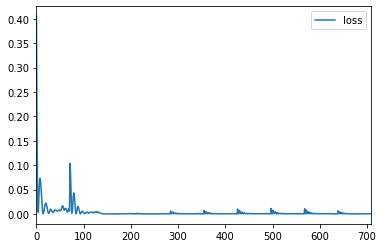

In [125]:
class Forecaster(tnn.Module):
    def __init__(self, seq_len=1, hidden_size=1):
        super(Forecaster, self).__init__()
        
        self.seq_len = seq_len
        self.hidden_size = hidden_size
        
        self.rnn = tnn.RNN(input_size=1, hidden_size=hidden_size)
        self.fc = tnn.Linear(seq_len, 1)
    
    def forward(self, ip):
        outs, h = self.rnn(ip)
#         return self.fc(outs.view(self.seq_len))
        return outs.view(3)
    
    def predict(self, ip):
        with torch.no_grad():
            pred = self.forward(ip)
        return pred

model = Forecaster(seq_len=SEQ_LEN, hidden_size=1)
loss_fn = tnn.MSELoss()
optimizer = top.Adam(model.parameters(), lr=0.1)

# TRAIN
loss_vals = []
pred_vals = []
num_epochs = 10

for e in range(num_epochs):
    for i, data in enumerate(data_loader):
        ip, op = data

        # set grads to 0
        optimizer.zero_grad()

        # predict
        pred = model(ip.view(SEQ_LEN, 1, 1))

        # calc loss
        loss = loss_fn(pred, op.view(3))

        # logging
        loss_vals.append(loss.item())
        if i%10 == 0:
            print("Epoch:", e, "Iter:", i, "Loss:", f"{loss.item(): .4f}", "Out:", f"{pred.view(3)[2].item()*10000: .2f}", "Ex:", f"{op.view(3)[2].item()*10000: .2f}")

        # assign grads
        loss.backward()

        # update weights
        optimizer.step()

df_loss = pd.DataFrame({
    'loss': loss_vals
})
df_loss.plot(
    y='loss'
)

### Test
- on a single value

In [127]:
test_in = np.array([1000, 1200, 1300]) / 10000
t = torch.tensor(
    test_in.reshape(3, 1, 1),
    dtype=torch.float32
)
out = model.predict(t)
print(out.view(3)[2].item() * 10000)

1253.13401222229


- on entire input

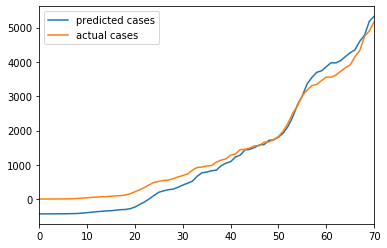

In [126]:
pred_vals = []
out_vals = []
for data in data_loader:
    ip, op = data
    pred = model.predict(ip.view(SEQ_LEN, 1, 1))
    pred_vals.append(pred.view(3)[2].item() * 10000)
    out_vals.append(op.view(3)[2].item() * 10000)

cmp_df = pd.DataFrame({
    'predicted cases': pred_vals,
    'actual cases': out_vals
})
cmp_df.plot()


In [73]:
for k in model.state_dict().keys():
    print(k, "=", model.state_dict()[k])

rnn.weight_ih_l0 = tensor([[-0.4787]])
rnn.weight_hh_l0 = tensor([[0.5714]])
rnn.bias_ih_l0 = tensor([-0.4862])
rnn.bias_hh_l0 = tensor([-0.3711])
fc.weight = tensor([[ 0.3509, -0.5119, -0.4539]])
fc.bias = tensor([-0.4916])
